In [14]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

import config
import numpy as np
import matplotlib.pylab as plt
from operator import attrgetter
import datetime as dt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 24 16:05:10 2023

@author: loren
"""
# Define non linear system


#dy1/dt = -a/N * y1*y2           
#dy2/dt = a/N * y1*y2 - b* y2    
#dy3/dt = b*y2                   

import numpy as np 
from numpy.linalg import inv
import matplotlib.pyplot as plt 

# Time Interval
t_start = 0
t_end = 180
n = 10000
# dt = (t_end - t_start)/n
dt = 0.05

iteration = 0

# Initial Guess Value in millions
y1 = 1218 * 10**6
y2 = 1936 * 10**6
y3 = 290.4 * 10**6

#constants
a = 0.0804
b = 0.0201
gamma = 0.00
N = y1+y2+y3

# Equation
#BE : y old + dt * g - y
#FE : y old + dt * g old - y
#TZ : y old + dt/2 (g old + g) - y
#ME : w = y old + dt * g old
    # and y old +dt/2 (g old + g(w)) - y

def f1(y1_old,y2_old,y3_old,y1,y2,y3,dt):
	return y1_old + (-a/N * y1*y2 + gamma*y3 -a/N * y1_old*y2_old + gamma*y3_old)*dt/2 - y1

def f2(y1_old,y2_old,y3_old,y1,y2,y3,dt):
	return y2_old + (a/N * y1*y2 - b* y2 + a/N * y1_old*y2_old - b*y2_old)*dt/2 - y2

def f3(y1_old,y2_old,y3_old,y1,y2,y3,dt):
	return y3_old + (b*y2+b*y2_old-gamma*y3-gamma*y3_old)*dt/2 - y3

# Jacobian Matrix
def jacobian(y1_old,y2_old,y3_old,y1,y2,y3,dt):
	J = np.zeros((3,3))
	h = 1e-5
    # we will use the limit definition of a derivativ, but then approximated by taking h very small.

	# First Row
	J[0,0] = (f1(y1_old,y2_old,y3_old,y1+h,y2,y3,dt)-f1(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h
	J[0,1] = (f1(y1_old,y2_old,y3_old,y1,y2+h,y3,dt)-f1(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h
	J[0,2] = (f1(y1_old,y2_old,y3_old,y1,y2,y3+h,dt)-f1(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h

	# Second Row 
	J[1,0] = (f2(y1_old,y2_old,y3_old,y1+h,y2,y3,dt)-f2(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h
	J[1,1] = (f2(y1_old,y2_old,y3_old,y1,y2+h,y3,dt)-f2(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h
	J[1,2] = (f2(y1_old,y2_old,y3_old,y1,y2,y3+h,dt)-f2(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h

	# Third Row
	J[2,0] = (f3(y1_old,y2_old,y3_old,y1+h,y2,y3,dt)-f3(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h
	J[2,1] = (f3(y1_old,y2_old,y3_old,y1,y2+h,y3,dt)-f3(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h
	J[2,2] = (f3(y1_old,y2_old,y3_old,y1,y2,y3+h,dt)-f3(y1_old,y2_old,y3_old,y1,y2,y3,dt))/h

	return J



# Newton Rhaphson Method
def Newton_Rhaphson(y1,y2,y3,y1_guess,y2_guess,y3_guess,dt):
	# Vector Equation
	global iteration
	Y_old = np.zeros((3,1))
	Y_old[0] = y1_guess
	Y_old[1] = y2_guess
	Y_old[2] = y3_guess
	#print(Y_old)

	F = np.zeros((3,1))

	# Solver Parameter
	error = 9e9
	tol = 1e-4
	alpha = 1
	#iter = 0

	while(error>=tol):
		# Jacobi set for the equation
		iteration = iteration + 1
		J = jacobian(y1,y2,y3,Y_old[0],Y_old[1],Y_old[2],dt)

		F[0] = f1(y1,y2,y3,Y_old[0],Y_old[1],Y_old[2],dt)
		F[1] = f2(y1,y2,y3,Y_old[0],Y_old[1],Y_old[2],dt)
		F[2] = f3(y1,y2,y3,Y_old[0],Y_old[1],Y_old[2],dt)

		Y_new = Y_old - alpha*(np.matmul(inv(J),F))
		error = np.max(np.abs(Y_new-Y_old))
		# print(error,tol)
		Y_old = Y_new
		#print(iter)
		log_message = "hoi"#'iteration = {0} y1 = {1} y2 = {2} y3 = {3}\'.format(iteration,Y_new[0],Y_new[1],Y_new[2])
		#print(log_message)
		#iter = iter + 1

	return [Y_new[0],Y_new[1],Y_new[2]]

# Implicit Euler

def implicit(y1,y2,y3,t_start,t_end,dt):
	t = np.arange(t_start,t_end,dt)
	time = len(t)

	Y_1 = np.zeros(time)
	Y_2 = np.zeros(time)
	Y_3 = np.zeros(time)

	Y_1[0] = y1
	Y_2[0] = y2
	Y_3[0] = y3

	y1_guess = 0
	y2_guess = 0
	y3_guess = 0

	for i in tqdm(range(1,time)):
		Y_1[i],Y_2[i],Y_3[i] = Newton_Rhaphson(Y_1[i-1],Y_2[i-1],Y_3[i-1],y1_guess,y2_guess,y3_guess,dt)
		y1_guess = Y_1[i]
		y2_guess = Y_2[i]
		y3_guess = Y_3[i]

	return [t,Y_1,Y_2,Y_3]

t, y1, y2, y3 = implicit(y1,y2,y3,t_start,t_end,dt)

In [41]:
N, I0, R0, S0, downloads_per_month, average_infection_rate, alpha, beta, t_start_milliseconds = attrgetter('N', 'I0', 'R0', 'S0', 'downloads_per_month', 'average_infection_rate', 'alpha', 'beta', 't_start_milliseconds')(config.FACEBOOK_SIR_CONSTANTS)
t_step = 1e-1
t_start = 0
t_end = 12 * 15

In [42]:
n_steps = int(1 + (t_end - t_start) / t_step) # FIXME:
t_arr = np.linspace(t_start, t_end, n_steps, endpoint=True)
S_arr = np.zeros(n_steps)
I_arr = np.zeros(n_steps)
R_arr = np.zeros(n_steps)
S_arr[0] = S0
I_arr[0] = I0
R_arr[0] = R0
for n, _ in enumerate(t_arr[:-1]):
    S_arr[n + 1] = S_arr[n] + t_step * (-alpha / N * S_arr[n] * I_arr[n])
    I_arr[n + 1] = I_arr[n] + t_step * (alpha / N * S_arr[n] * I_arr[n] - beta * I_arr[n])
    R_arr[n + 1] = R_arr[n] + t_step * (beta * I_arr[n])

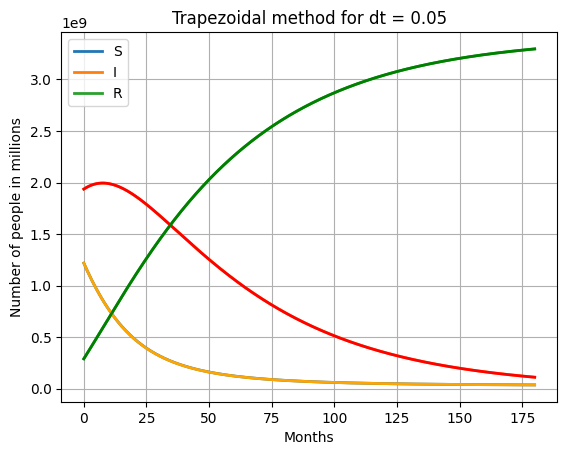

In [45]:
FIGURE_WIDTH = 6.4
FIGURE_HEIGHT = 4.8
LINEWIDTH = 2


plt.plot(t,y1, linewidth=LINEWIDTH)
plt.plot(t,y2, linewidth=LINEWIDTH)
plt.plot(t,y3, linewidth=LINEWIDTH)
plt.xlabel('Months')
plt.ylabel('Number of people in millions')
plt.legend(['S','I','R'])
title = "Trapezoidal method for dt = " + str(dt)
plt.title(title)
plt.grid('on')

plt.plot(t_arr, S_arr, color='orange', label='S', linewidth=LINEWIDTH)
plt.plot(t_arr, I_arr, color='red', label='I', linewidth=LINEWIDTH)
plt.plot(t_arr, R_arr, color='green', label='R', linewidth=LINEWIDTH)
plt.show()
